Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and Hyperopt for hyperparameter tuning.

**Note:**
- Selected date range 1/1/2019 - 12/1/2020
- registered_only = False

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/Imbalance/Churn_Imbalance_XGB_Hyperopt_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 12, 1)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2019, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = False
mlflow.log_param("Setup complete", registered_only)

# over-sample minority and under-sample majority
over_sample = False 
under_sample = False
mlflow.log_param("over_sample", over_sample)
mlflow.log_param("under_sample", under_sample)

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

billable companies: 10886

In [0]:
df['InstanceId'].value_counts()

Out[56]: 50 2793
53 517
Name: InstanceId, dtype: int64

all companies with licenses: 5111

In [0]:
mlflow.log_param("Instances", df['InstanceId'].value_counts())

More filtering before modeling

In [0]:
df.describe(include='all')

Out[58]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
count,3310.000000,3310.00000,3310,3304.000000,3310,3310.0,3310.000000,3310,3236,799,3222,3310,3310,3310,2454,2451,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
unique,NaN,NaN,3255,NaN,2,NaN,NaN,3249,1747,53,2335,6,1,610,625,2445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,EXCEL REAL ESTATE MANAGEMENT,NaN,False,NaN,NaN,EXCEL REAL ESTATE MANAGEMENT,NEW YORK,CA,48180,US,en-US,2020-02-29 00:00:00,2020-08-28,2020-06-07 00:04:51.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,9,NaN,2264,NaN,NaN,9,62,125,12,3275,3310,35,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00,NaN,2019-01-14 00:11:00.370000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-18 23:25:16.280000,NaN,2020-12-09 00:03:09.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22077.543202,50.46858,NaN,14.828692,NaN,0.0,18095.275529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.594864,0.726284,19.888218,0.878550,2008.872205,207.652568,97.274018,65.734441
std,14223.110383,1.08928,NaN,8.485728,NaN,0.0,3166.836160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.918082,0.445932,43.060201,4.836998,12367.448097,2016.213672,868.027453,1623.197772
min,2434.000000,50.00000,NaN,2.000000,NaN,0.0,2520.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15511.250000,50.00000,NaN,10.000000,NaN,0.0,15187.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Categorical feature distributions

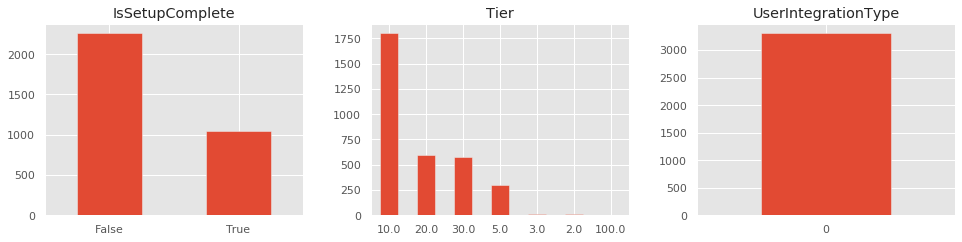

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

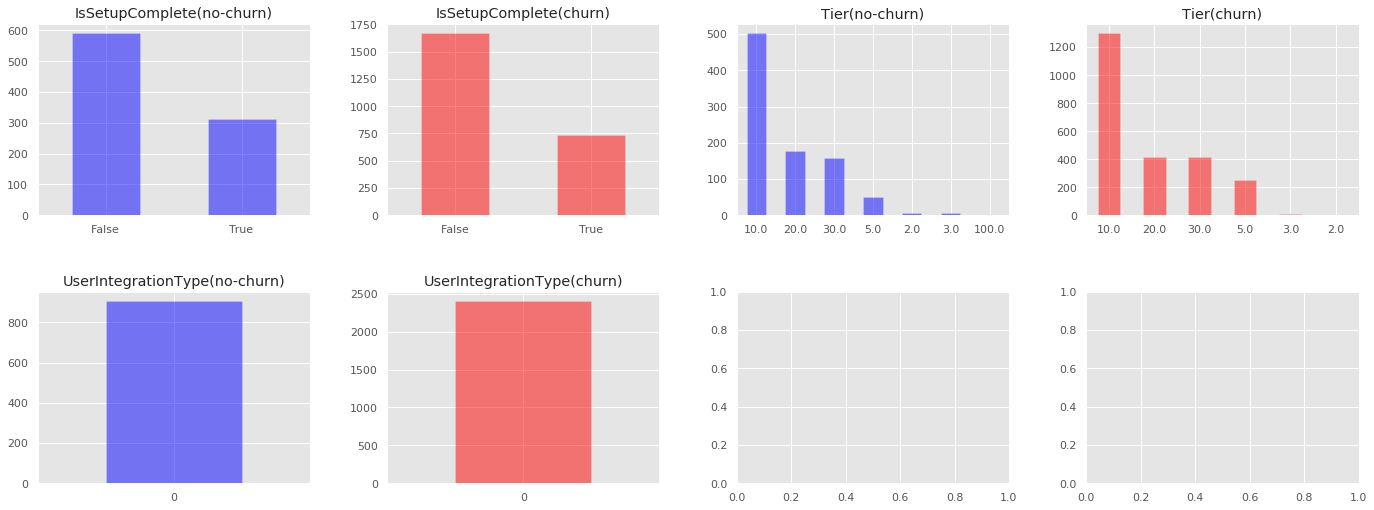

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('IsSetupComplete(no-churn)')
df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('IsSetupComplete(churn)')

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('UserIntegrationType(churn)')

fig.tight_layout(pad=4.0)


Numerical feature distributions

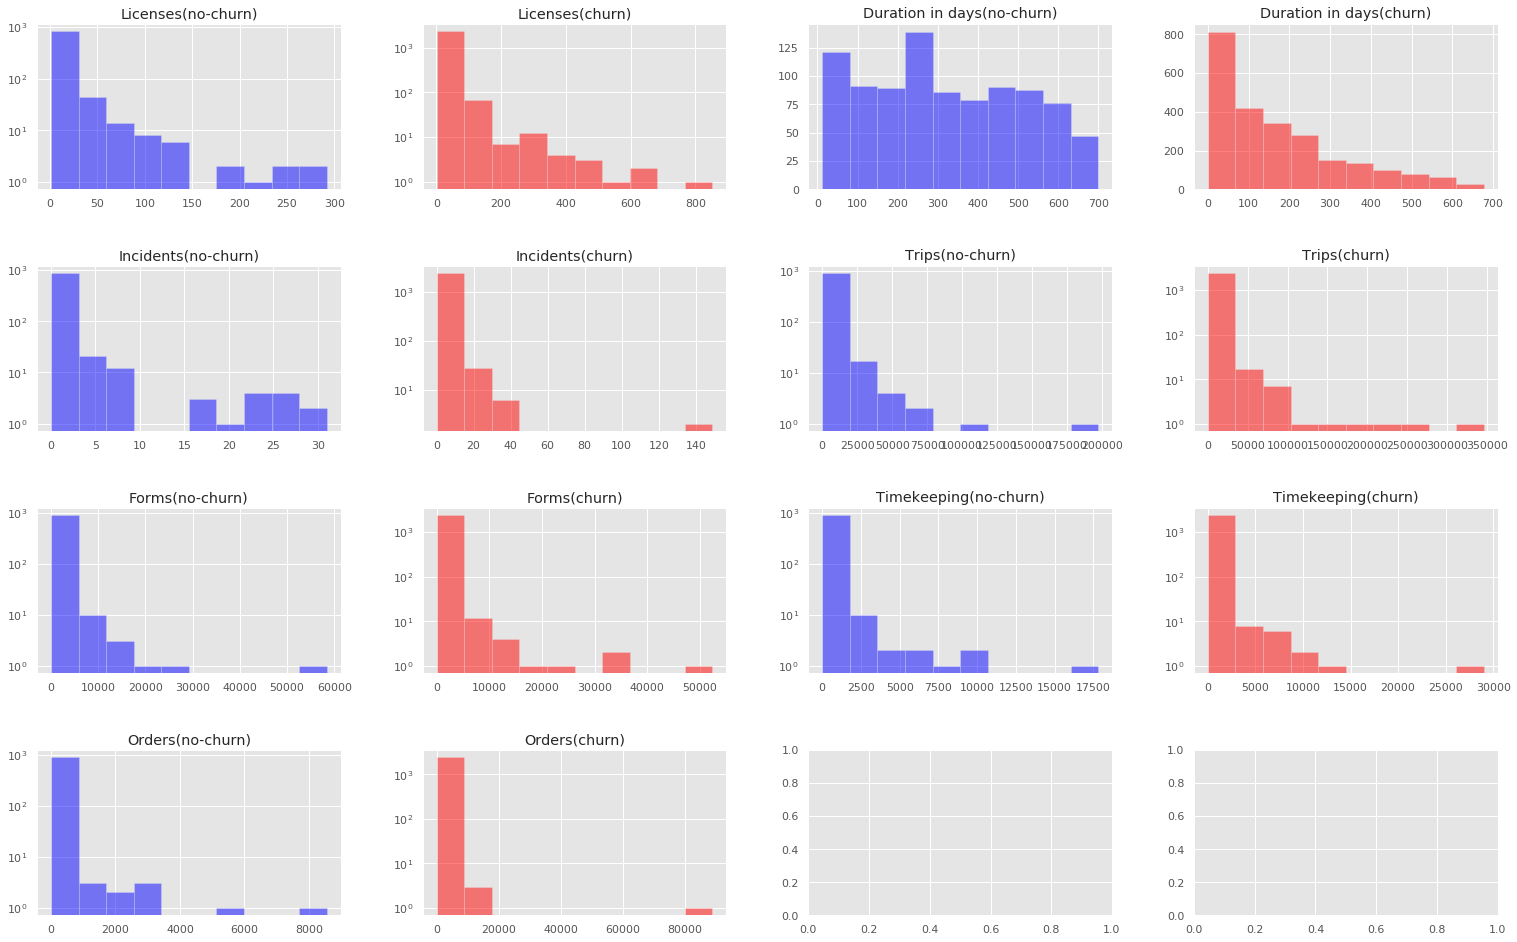

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df = df[categorical_features + [target] + numerical_features]

df.corr()

Out[62]:

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
IsSetupComplete,1.000000,0.209460,NaN,-0.040361,0.156411,0.080482,0.120665,0.233539,0.151334,0.164668,0.023966
Tier,0.209460,1.000000,NaN,-0.032556,0.049063,-0.038038,0.025177,0.016241,0.130023,0.102065,0.121826
UserIntegrationType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,-0.040361,-0.032556,NaN,1.000000,0.085691,-0.357282,0.016388,-0.000979,-0.034291,-0.023504,0.010073
Licenses,0.156411,0.049063,NaN,0.085691,1.000000,0.110375,0.228183,0.507972,0.260866,0.239045,0.046238
Duration,0.080482,-0.038038,NaN,-0.357282,0.110375,1.000000,0.078044,0.130091,0.093853,0.082654,0.001634
Incidents,0.120665,0.025177,NaN,0.016388,0.228183,0.078044,1.000000,0.138312,0.110509,0.068261,0.026766
Trips,0.233539,0.016241,NaN,-0.000979,0.507972,0.130091,0.138312,1.000000,0.187125,0.427150,0.066596
Forms,0.151334,0.130023,NaN,-0.034291,0.260866,0.093853,0.110509,0.187125,1.000000,0.124686,0.069692
Timekeeping,0.164668,0.102065,NaN,-0.023504,0.239045,0.082654,0.068261,0.427150,0.124686,1.000000,0.023365


Out[63]:

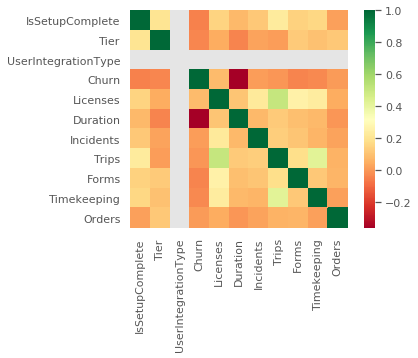

<matplotlib.axes._subplots.AxesSubplot at 0x7ff933df9590>

In [0]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

Create dummy variables for categorical variables

In [0]:
# cat_vars=['IsSetupComplete','Tier','UserIntegrationType']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1
    
# df_vars=df.columns.values.tolist()
# to_keep=[i for i in df_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

In [0]:
df_final = df
df_final.head()

Out[65]:

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10.0,0,1,16,2,0,3748,0,0,0
1,True,30.0,0,0,7,315,0,0,5,11,1
2,False,10.0,0,1,14,203,0,0,0,0,0
3,False,10.0,0,1,23,420,0,0,0,0,0
4,False,5.0,0,1,3,94,0,0,0,0,0


In [0]:
mlflow.log_param("dataset shape", df_final.shape)

**Training**

In [0]:
# --- training with SMOTE ---
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

# SMOTENC is the only one that handles categorical values.
oversample = SMOTENC(k_neighbors=1, random_state=0, sampling_strategy=0.3, categorical_features=[0,1,2])
# oversample = SMOTENC(random_state=0, categorical_features=[0,1,2])

# under-sample
undersample = TomekLinks()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
columns = X_train.columns

if over_sample:
  data_X, data_y = oversample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])
  
if under_sample:
  data_X, data_y = undersample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])

# we can Check the numbers of our data
print("length of data is ",len(X_train))
print("Number of no churn in  data",len(y_train[y_train['Churn']==0]))
print("Number of churn",len(y_train[y_train['Churn']==1]))
print("Proportion of no churn data in data is ",len(y_train[y_train['Churn']==0])/len(X_train))
print("Proportion of churn data in data is ",len(y_train[y_train['Churn']==1])/len(X_train))


length of data is 2482
Number of no churn in data 691
Number of churn 1791
Proportion of no churn data in data is 0.2784045124899275
Proportion of churn data in data is 0.7215954875100725

In [0]:
X.head()

Out[68]:

,IsSetupComplete,Tier,UserIntegrationType,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10.0,0,16,2,0,3748,0,0,0
1,True,30.0,0,7,315,0,0,5,11,1
2,False,10.0,0,14,203,0,0,0,0,0
3,False,10.0,0,23,420,0,0,0,0,0
4,False,5.0,0,3,94,0,0,0,0,0


In [0]:
# training the model
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# define space
space = {
    # complexity
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "min_child_weight": hp.uniform("min_child_weight", 1, 2),
    "gamma": hp.uniform("gamma", 1, 9),
    "n_estimators": hp.quniform("n_estimators", 100, 150, 1), # default 100
    # noise
    "learning_rate": hp.uniform("learning_rate", 0.03, 0.2), # default 0.1    
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.8, 1),
    # imbalance
    "scale_pos_weight": hp.uniform("scale_pos_weight", 0.3, 2)
}

# define objective func
def hyperparameter_tuning(space):
    model = XGBClassifier(n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          min_child_weight = space['min_child_weight'],
                          gamma = space['gamma'],
                          learning_rate = space['learning_rate'],
                          subsample = space['subsample'],
                          colsample_bytree = space['colsample_bytree'],
                          scale_pos_weight = space['scale_pos_weight'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, np.ravel(y_train),
            eval_set=evaluation, #eval_metric="auc", #rmse
            early_stopping_rounds=10,verbose=False)

    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, scoring='roc_auc')
#     accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    accuracy = accuracies.mean()
#     pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     accuracy = roc_auc_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': 1-accuracy, 'status': STATUS_OK}

mlflow.log_param("scoring", "roc_auc")

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print (best)

0%| | 0/200 [00:00<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:01<?, ?trial/s, best loss=?] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 0/200 [00:01<?, ?trial/s, best loss=?] SCORE:
 0%| | 0/200 [00:01<?, ?trial/s, best loss=?] 0.792686712306349
 0%| | 0/200 [00:01<?, ?trial/s, best loss=?] 0%| | 1/200 [00:01<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00:01<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00:01<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00:02<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00:02<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00:02<06:00, 1.81s/trial, best loss: 0.20731328769365098] /databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

 0%| | 1/200 [00

Use best model to get all metrics

In [0]:
clf = XGBClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
mlflow.log_param("RepeatedStratifiedKFold", cv)

# ****** GridSearchCV *************
param_grid = {
    # complexity
    "max_depth": [int(best["max_depth"])],
    "min_child_weight": [best["min_child_weight"]],
    "gamma":  [best["gamma"]],
    "n_estimators":  [int(best["n_estimators"])],
    # noise
    "learning_rate":  [best["learning_rate"]],   
    "subsample":  [best["subsample"]],
    "colsample_bytree":  [best["colsample_bytree"]],
    # imbalance
    "scale_pos_weight":  [best["scale_pos_weight"]]
}

tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='roc_auc')
tree_cv.fit(X_train, np.ravel(y_train))
pred = tree_cv.predict(X_test)

print("Tuned XGBoost: {}".format(tree_cv.best_params_))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", tree_cv.best_params_)
mlflow.sklearn.log_model(tree_cv, "model")
mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))

Tuned XGBoost: {'colsample_bytree': 0.9811940093289202, 'gamma': 8.651392862581163, 'learning_rate': 0.10310914879686134, 'max_depth': 13, 'min_child_weight': 1.1389678541540391, 'n_estimators': 112, 'scale_pos_weight': 1.7742457119186457, 'subsample': 0.6830706939322275}
Accuracy of XGBoost classifier on test set: 0.82

**Testing **

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

# print(classification_report(y_test, pred, labels=np.unique(pred), zero_division=0))
print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.78 0.31 0.44 215
 1 0.80 0.97 0.88 613

 accuracy 0.80 828
 macro avg 0.79 0.64 0.66 828
weighted avg 0.79 0.80 0.76 828

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

**Model Interpretation**

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.9811940093289202,
 gamma=8.651392862581163, gpu_id=-1, importance_type='gain',
 interaction_constraints='', learning_rate=0.10310914879686134,
 max_delta_step=0, max_depth=13,
 min_child_weight=1.1389678541540391, missing=nan,
 monotone_constraints='()', n_estimators=112, n_jobs=0,
 num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
 scale_pos_weight=1.7742457119186457, subsample=0.6830706939322275,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['IsSetupComplete', 'Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

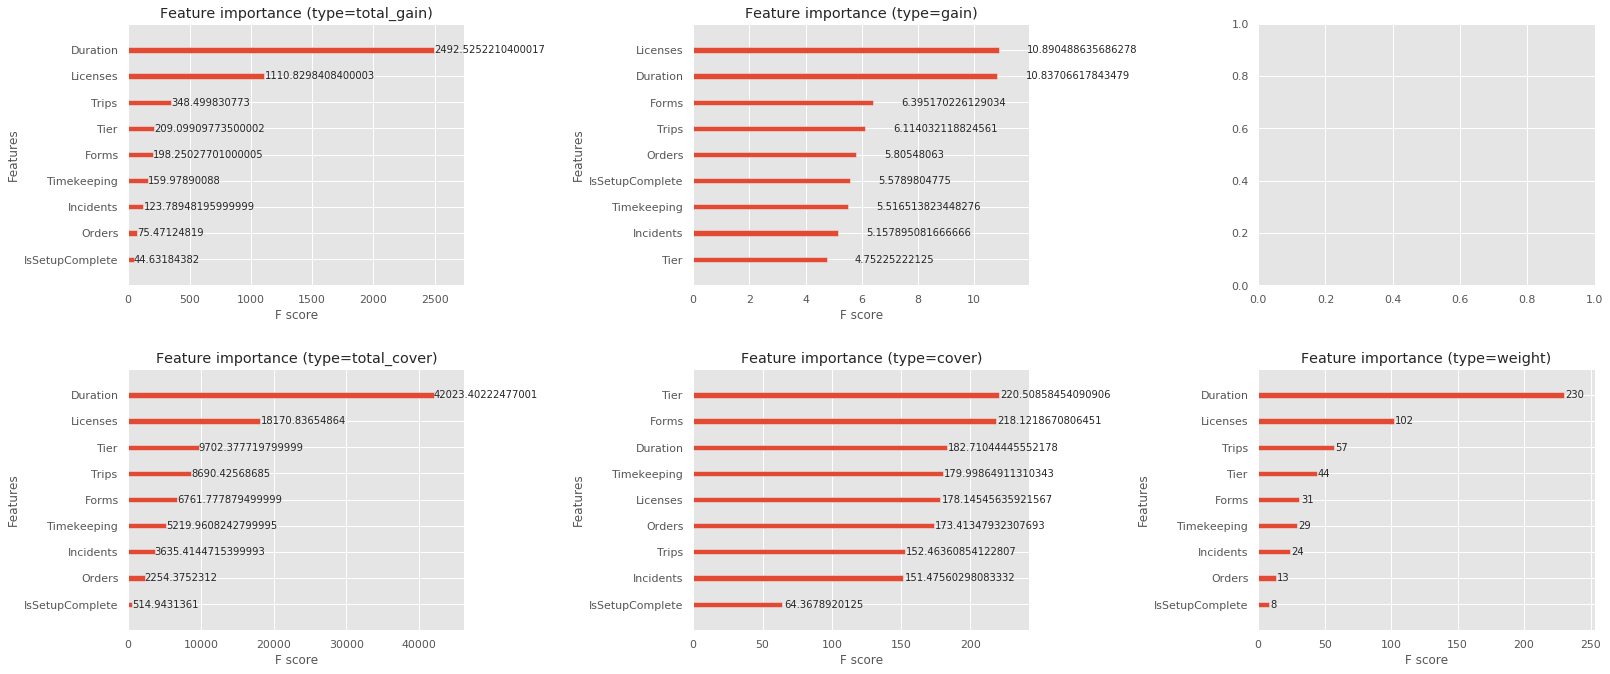

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

ROC Curve for test data

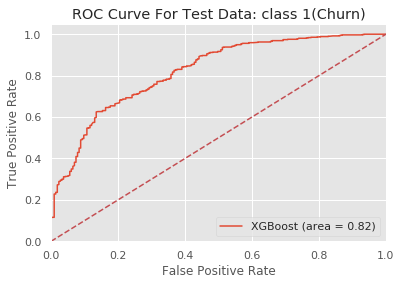

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

tree_roc_auc = roc_auc_score(y_test, tree_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_cv.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 test data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Test Data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()


ROC Curve for train data

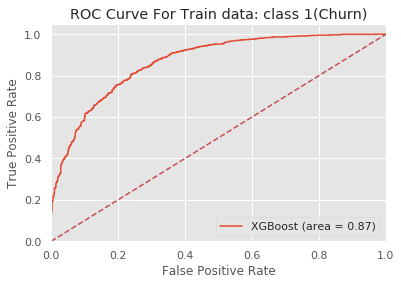

In [0]:
tree_roc_auc = roc_auc_score(y_train, tree_cv.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_cv.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 train data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Train data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

roc_auc for traning data is 0.85, and 0.81 for test data. It is the decent fit.

In [0]:
mlflow.end_run()